<a href="https://colab.research.google.com/github/muwudev/Diabetes-Classifier/blob/main/diabetes_classification_using_RF_SVM_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. drug classification with SVM and Random Forests

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
import seaborn as sbs

from sklearn.model_selection import GridSearchCV # for optimisation, best combination of hyperparameters
from sklearn.model_selection import cross_val_score # for model performance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/diabetes.csv')

In [ ]:
# summary stats before - table 1.1
df.describe(include='all').round(2)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.85,120.89,69.11,20.54,79.80,31.99,0.47,33.24,0.35
std,3.37,31.97,19.36,15.95,115.24,7.88,0.33,11.76,0.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.08,21.00,0.00
25%,1.00,99.00,62.00,0.00,0.00,27.30,0.24,24.00,0.00
50%,3.00,117.00,72.00,23.00,30.50,32.00,0.37,29.00,0.00
75%,6.00,140.25,80.00,32.00,127.25,36.60,0.63,41.00,1.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00,1.00


In [ ]:
df[df.eq(0)==True].count()

,0
Pregnancies,111
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11
DiabetesPedigreeFunction,0
Age,0
Outcome,500


In [ ]:
column_sums = df.sum().round(2)

# Convert the sums to a DataFrame for better presentation
sums_df = pd.DataFrame(column_sums, columns=['Sum']).T

sums_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Sum,2953.0,92847.0,53073.0,15772.0,61286.0,24570.3,362.4,25529.0,268.0


2. Replacing missing values with avg (median, mean)



In [ ]:
# replace missing values with median - columns -  Glucose, BloodPressure, SkinThickness, BMI
columns_to_process = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'Insulin']

# Iterate over each column, calculate the , and replace 0s with the
for column in columns_to_process:
    median = df[column].median()
    df[column] = df[column].replace(0, median)

In [ ]:
df[df.eq(0)==True].count()

,0
Pregnancies,111
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,500


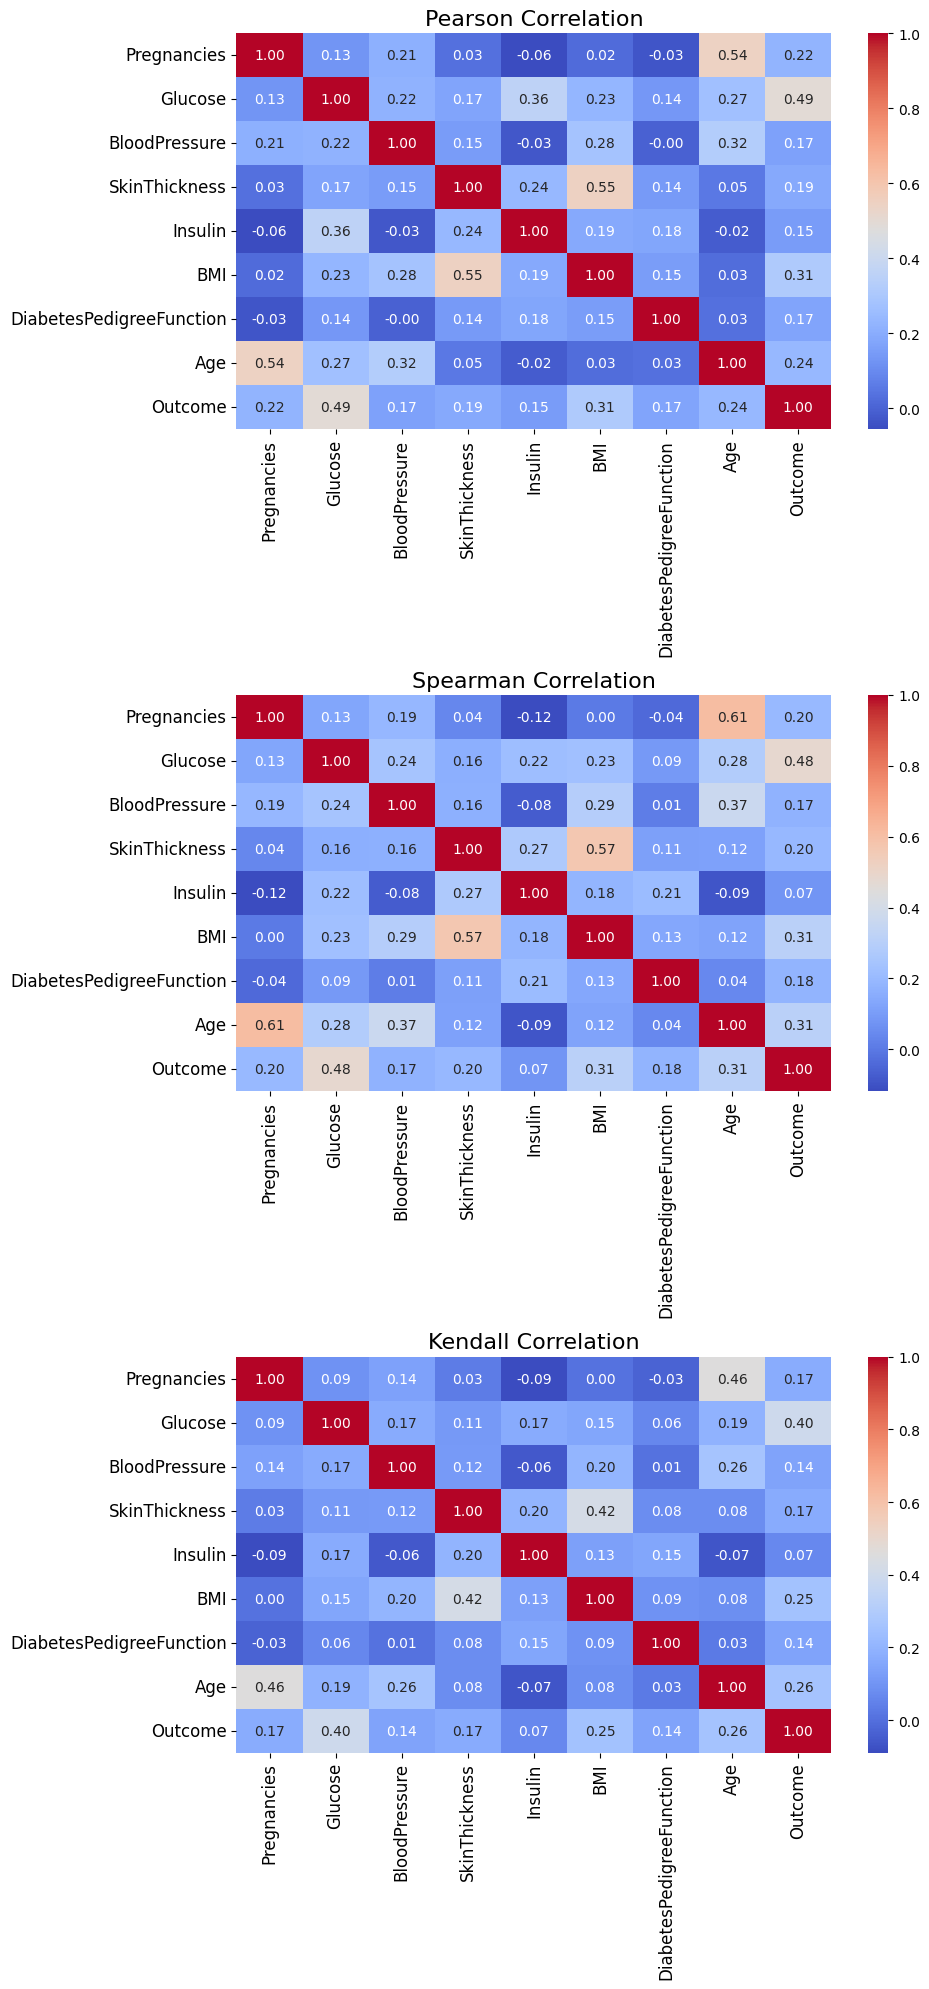

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume 'df' is your DataFrame

# Compute correlation matrices
pearson_corr = df.corr(method='pearson')
spearman_corr = df.corr(method='spearman')
kendall_corr = df.corr(method='kendall')

# Plot heatmaps
fig, axes = plt.subplots(3, 1, figsize=(10, 20))  # Adjust figsize for vertical alignment

# Plot Pearson correlation heatmap
sns.heatmap(pearson_corr, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[0], cbar=True)
axes[0].set_title('Pearson Correlation', fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=12)  # Adjust label size

# Plot Spearman correlation heatmap
sns.heatmap(spearman_corr, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1], cbar=True)
axes[1].set_title('Spearman Correlation', fontsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=12)  # Adjust label size

# Plot Kendall correlation heatmap
sns.heatmap(kendall_corr, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[2], cbar=True)
axes[2].set_title('Kendall Correlation', fontsize=16)
axes[2].tick_params(axis='both', which='major', labelsize=12)  # Adjust label size

plt.tight_layout()
plt.show()






In [ ]:
column_sums = df.sum().round(2)

# Convert the sums to a DataFrame for better presentation
sums_df = pd.DataFrame(column_sums, columns=['Sum']).T

sums_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Sum,2953.0,93432.0,55593.0,20993.0,72693.0,24922.3,362.4,25529.0,268.0


feature engineering

In [ ]:
def create_new_bmi(df):
    new_cat = "NEW_BMI_CAT"
    df.loc[(df['BMI'] < 18.5), new_cat] = "underweight"
    df.loc[(df['BMI'] > 18.5) & (df['BMI'] < 25), new_cat] = "normal"
    df.loc[(df['BMI'] > 24) & (df['BMI'] < 30), new_cat] =  "overweight"
    df.loc[(df['BMI'] > 30) & (df['BMI']< 40), new_cat] = "obese"
    df.drop('BMI', axis=1, inplace=True)
    df[new_cat] = df[new_cat].astype('category')

def create_new_glucose(df):
    new_cat = "NEW_GLUCOSE_CAT"
    df.loc[(df['Glucose'] < 70), new_cat] = "low"
    df.loc[(df['Glucose'] > 70) & (df['Glucose'] < 99), new_cat] = "normal"
    df.loc[(df['Glucose'] > 99) & (df['Glucose'] < 126), new_cat] = "high"
    df.loc[(df['Glucose'] > 126) & (df['Glucose'] < 200), new_cat] = "very_high"
    df[new_cat] = df[new_cat].astype('category')


def create_new_skinthickness(df):
    new_cat = "NEW_SKIN_THICKNESS"
    df.loc[df['SkinThickness'] < 30, new_cat] = "normal"
    df.loc[df['SkinThickness'] >= 70, new_cat] = "highfat"
    df[new_cat] = df[new_cat].astype('category')

def create_new_pregnancies(df):
    new_cat = "NEW_PREGNANCIES"
    df.loc[df['Pregnancies'] == 0, new_cat] = "no_pregnancies"
    df.loc[(df['Pregnancies'] > 0) & df['Pregnancies'] <= 4, new_cat] = "std_pregnancies"
    df.loc[(df['Pregnancies'] > 4), new_cat] = "over_pregnancies"
    df[new_cat] = df[new_cat].astype('category')

def create_circulation_level(df):
    new_cat = "NEW_CIRCULATION_LEVEL"
    df.loc[(df['SkinThickness'] < 30) & (df['BloodPressure'] < 80), new_cat] = "normal"
    df.loc[(df['SkinThickness'] > 30) & (df['BloodPressure']>= 80), new_cat] = "high_risk"
    df.loc[((df['SkinThickness']< 30) & (df['BloodPressure'] >=80)) | ((df['SkinThickness']> 30) & (df['BloodPressure'] <80)), new_cat] = "medium_risk"
    df[new_cat] = df[new_cat].astype('category')
    df.drop('SkinThickness', axis=1, inplace=True)

def create_other_features(df):
    df['PRE_AGE_CAT'] = df['Age'] * df['Pregnancies']
    df['INSULIN_GLUCOSE_CAT'] = df['Insulin'] * df['Glucose']
    df.drop('Pregnancies', axis=1, inplace=True)
    df.drop('Glucose', axis=1, inplace=True)

create_new_bmi(df)
create_new_glucose(df)
create_new_pregnancies(df)
create_new_skinthickness(df)
create_circulation_level(df)
create_other_features(df)
df

label encoding

In [ ]:
df['NEW_CIRCULATION_LEVEL'].dtype.name == 'category'

True

In [ ]:
len(df['NEW_CIRCULATION_LEVEL'].unique())


4

In [ ]:
label_encoder = preprocessing.LabelEncoder()
df['Outcome'] = label_encoder.fit_transform(df['Outcome'])

one hot encoding

In [ ]:
categ_cols = [col for col in df.columns if df[col].dtype.name == 'category']
print(categ_cols)

['NEW_BMI_CAT', 'NEW_GLUCOSE_CAT', 'NEW_PREGNANCIES', 'NEW_SKIN_THICKNESS', 'NEW_CIRCULATION_LEVEL']


In [ ]:
def one_hot_encoder(df, columns):
    df_dummy = df.copy()
    df_dummy = pd.get_dummies(df, columns=columns, drop_first=True)
    return df_dummy

result = one_hot_encoder(df, categ_cols)
result

,BloodPressure,Insulin,DiabetesPedigreeFunction,Age,Outcome,PRE_AGE_CAT,INSULIN_GLUCOSE_CAT,NEW_BMI_CAT_normal,NEW_BMI_CAT_obese,NEW_BMI_CAT_overweight,...,NEW_GLUCOSE_CAT_low,NEW_GLUCOSE_CAT_nan,NEW_GLUCOSE_CAT_normal,NEW_GLUCOSE_CAT_very_high,NEW_PREGNANCIES_std_pregnancies,NEW_SKIN_THICKNESS_nan,NEW_SKIN_THICKNESS_normal,NEW_CIRCULATION_LEVEL_medium_risk,NEW_CIRCULATION_LEVEL_nan,NEW_CIRCULATION_LEVEL_normal
0,72,30.5,0.627,50,1,300,4514.0,False,True,False,...,False,False,False,True,False,True,False,True,False,False
1,66,30.5,0.351,31,0,31,2592.5,False,False,True,...,False,False,True,False,True,False,True,False,False,True
2,64,30.5,0.672,32,1,256,5581.5,True,False,False,...,False,False,False,True,False,False,True,False,False,True
3,66,94.0,0.167,21,0,21,8366.0,False,False,True,...,False,False,True,False,True,False,True,False,False,True
4,40,168.0,2.288,33,1,0,23016.0,False,False,False,...,False,False,False,True,True,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,76,180.0,0.171,63,0,630,18180.0,False,True,False,...,False,False,False,False,False,True,False,True,False,False
764,70,30.5,0.340,27,0,54,3721.0,False,True,False,...,False,False,False,False,True,False,True,False,False,True
765,72,112.0,0.245,30,0,150,13552.0,False,False,True,...,False,False,False,False,False,False,True,False,False,True
766,60,30.5,0.349,47,1,47,3843.0,False,True,False,...,False,True,False,False,True,False,True,False,False,True


In [ ]:
# preparing data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming 'Outcome' is the target column
X = result.drop(columns='Outcome')
y = result['Outcome']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize classifiers
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators=50, random_state=42)
svm = SVC(probability=True, random_state=42)
knn = KNeighborsClassifier()

# Train and evaluate models
models = {'Decision Tree': dt, 'Random Forest': rf, 'SVM': svm, 'KNN': knn}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}')

# Bagging with Decision Trees
bagging_tree = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
bagging_tree.fit(X_train, y_train)
y_pred_bagging_tree = bagging_tree.predict(X_test)
print(f'Bagging with Decision Trees Accuracy: {accuracy_score(y_test, y_pred_bagging_tree):.4f}')

# Bagging with KNN
bagging_knn = BaggingClassifier(base_estimator=KNeighborsClassifier(), n_estimators=50, random_state=42)
bagging_knn.fit(X_train, y_train)
y_pred_bagging_knn = bagging_knn.predict(X_test)
print(f'Bagging with KNN Accuracy: {accuracy_score(y_test, y_pred_bagging_knn):.4f}')

# Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('dt', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('svm', SVC(probability=True, random_state=42)),
    ('knn', KNeighborsClassifier())
], voting='soft')
voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)
print(f'Voting Classifier Accuracy: {accuracy_score(y_test, y_pred_voting):.4f}')

# Stacking Classifier
base_models = [
    ('dt', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('svm', SVC(probability=True, random_state=42)),
    ('knn', KNeighborsClassifier())
]
meta_model = LogisticRegression()
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)
stacking_clf.fit(X_train, y_train)
y_pred_stacking = stacking_clf.predict(X_test)
print(f'Stacking Classifier Accuracy: {accuracy_score(y_test, y_pred_stacking):.4f}')

Decision Tree Accuracy: 0.6277
Random Forest Accuracy: 0.7316
SVM Accuracy: 0.7143
KNN Accuracy: 0.6840


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging with Decision Trees Accuracy: 0.7359


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging with KNN Accuracy: 0.6797
Voting Classifier Accuracy: 0.6970
Stacking Classifier Accuracy: 0.7143


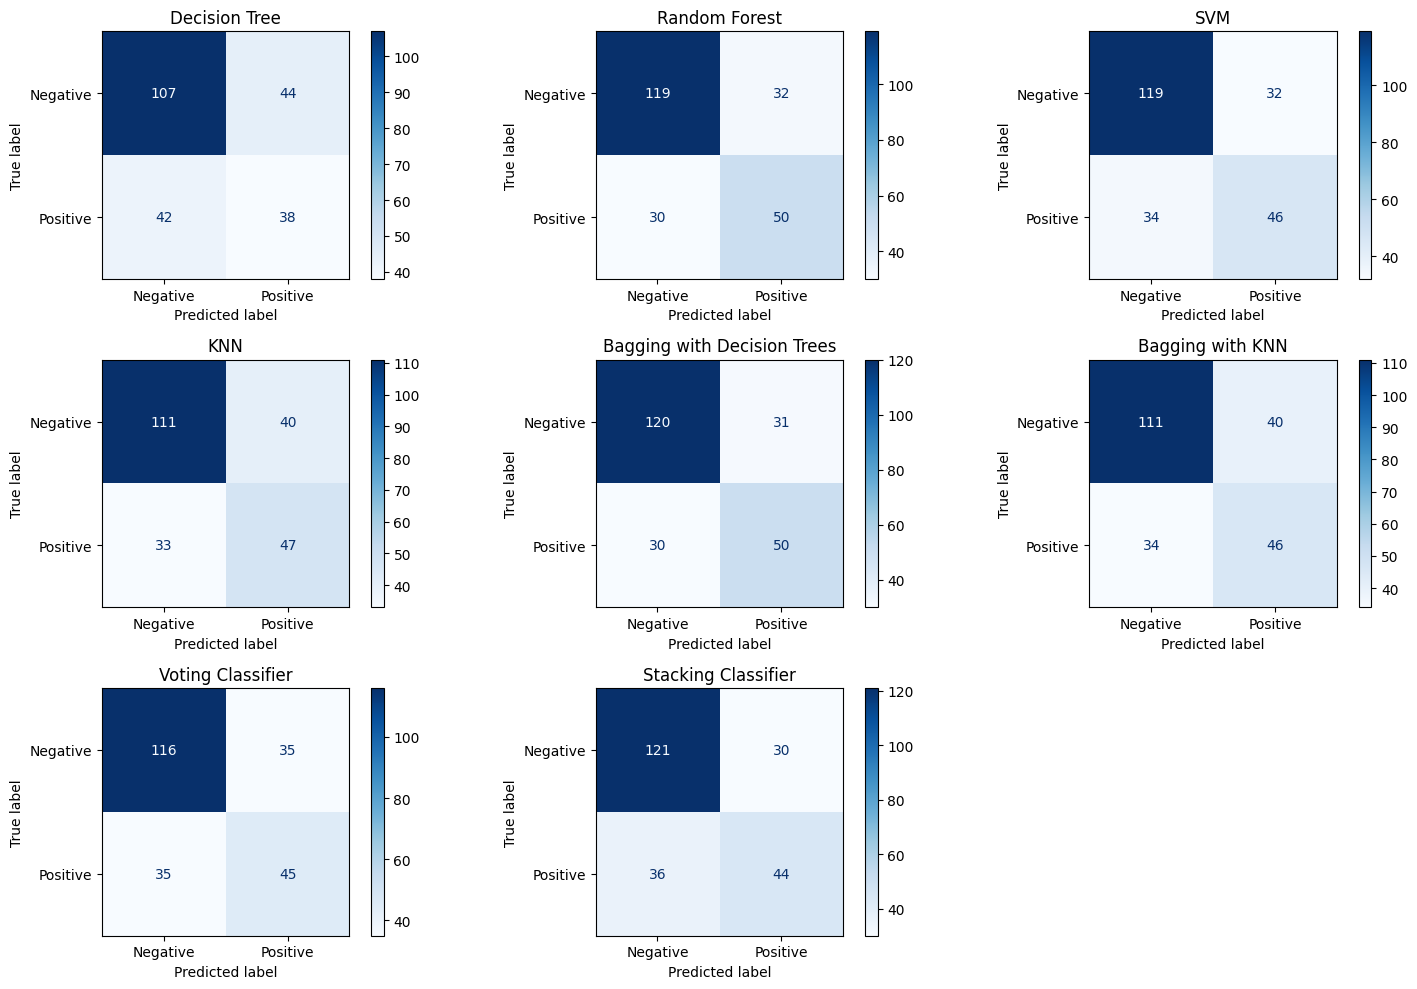

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot confusion matrix for each model
models = {
    'Decision Tree': dt,
    'Random Forest': rf,
    'SVM': svm,
    'KNN': knn,
    'Bagging with Decision Trees': bagging_tree,
    'Bagging with KNN': bagging_knn,
    'Voting Classifier': voting_clf,
    'Stacking Classifier': stacking_clf
}

plt.figure(figsize=(15, 10))
for i, (name, model) in enumerate(models.items(), 1):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
    plt.subplot(3, 3, i)
    disp.plot(ax=plt.gca(), cmap='Blues', values_format='d')
    plt.title(name)

plt.tight_layout()
plt.show()


ROC curve

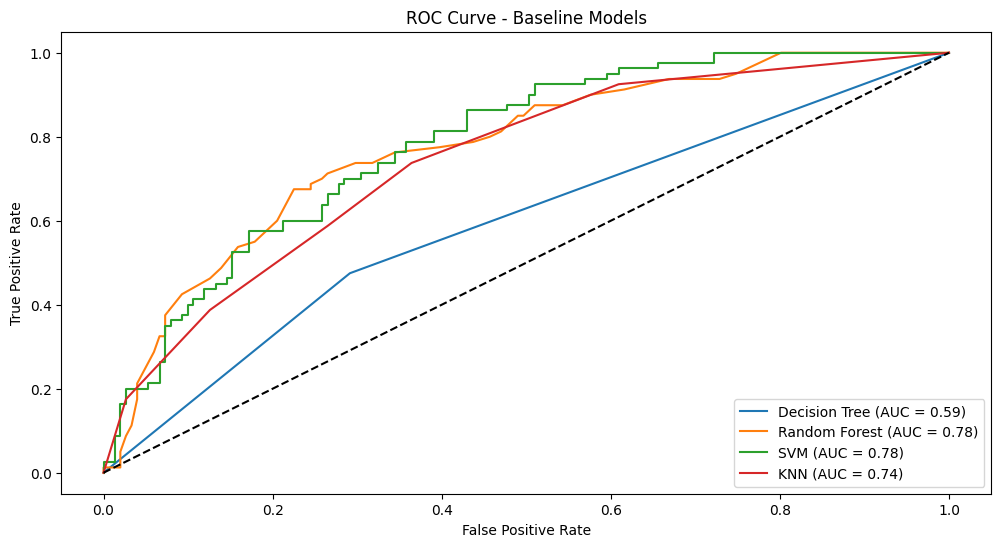

In [ ]:
from sklearn.metrics import roc_curve, auc

# Baseline models
baseline_models = {
    'Decision Tree': dt,
    'Random Forest': rf,
    'SVM': svm,
    'KNN': knn
}

# Plot ROC curves for baseline models
plt.figure(figsize=(12, 6))
for name, model in baseline_models.items():
    y_prob = model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Baseline Models')
plt.legend(loc='lower right')
plt.show()

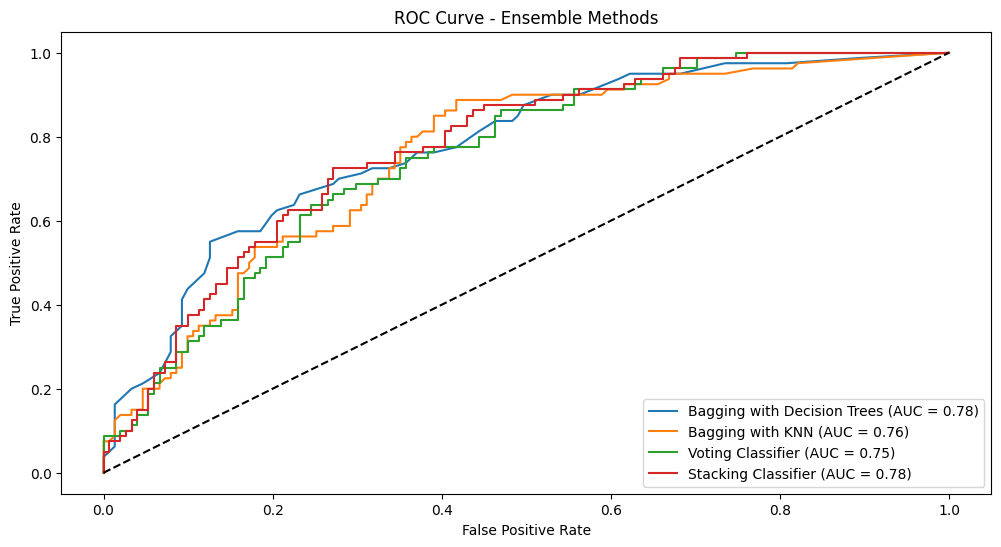

In [ ]:
# ensemble
# Ensemble models
ensemble_models = {
    'Bagging with Decision Trees': bagging_tree,
    'Bagging with KNN': bagging_knn,
    'Voting Classifier': voting_clf,
    'Stacking Classifier': stacking_clf
}

# Plot ROC curves for ensemble models
plt.figure(figsize=(12, 6))
for name, model in ensemble_models.items():
    y_prob = model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ensemble Methods')
plt.legend(loc='lower right')
plt.show()

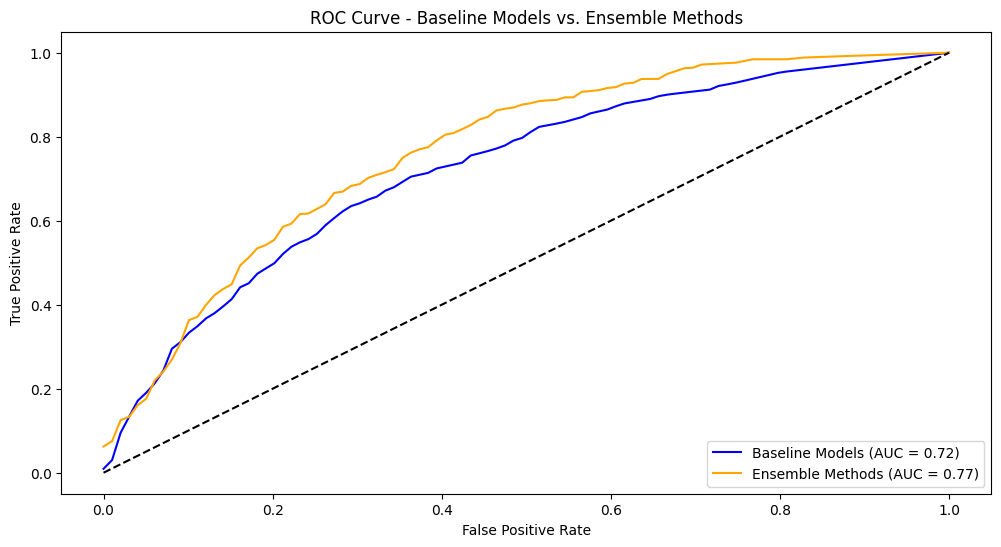

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Function to compute average ROC curve
def average_roc_curves(models, X_test, y_test):
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)
    mean_auc = 0

    for model in models:
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        mean_auc += auc(fpr, tpr)

    mean_tpr /= len(models)
    mean_auc /= len(models)

    return mean_fpr, mean_tpr, mean_auc

# Baseline models
baseline_models = [dt, rf, svm, knn]
fpr_baseline, tpr_baseline, auc_baseline = average_roc_curves(baseline_models, X_test, y_test)

# Ensemble models
ensemble_models = [bagging_tree, bagging_knn, voting_clf, stacking_clf]
fpr_ensemble, tpr_ensemble, auc_ensemble = average_roc_curves(ensemble_models, X_test, y_test)

# Plot ROC curves
plt.figure(figsize=(12, 6))
plt.plot(fpr_baseline, tpr_baseline, label=f'Baseline Models (AUC = {auc_baseline:.2f})', color='blue')
plt.plot(fpr_ensemble, tpr_ensemble, label=f'Ensemble Methods (AUC = {auc_ensemble:.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Baseline Models vs. Ensemble Methods')
plt.legend(loc='lower right')
plt.show()


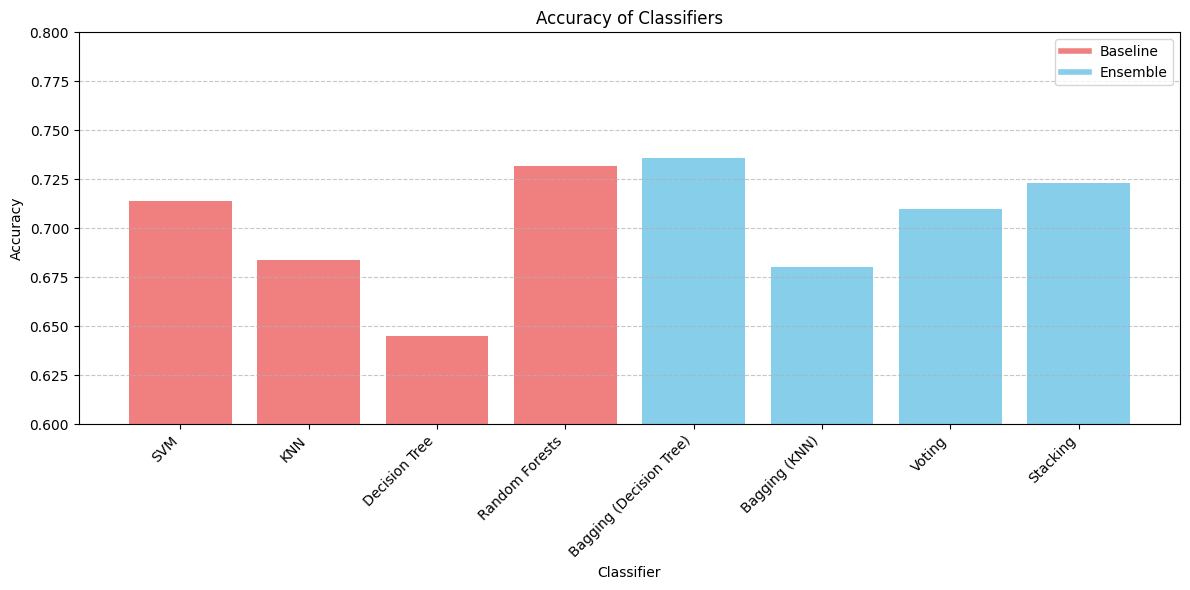

In [ ]:
import matplotlib.pyplot as plt

# Data
classifiers = [
    'SVM', 'KNN', 'Decision Tree', 'Random Forests',
    'Bagging (Decision Tree)', 'Bagging (KNN)',
    'Voting', 'Stacking'
]
accuracy = [
    0.714, 0.684, 0.645, 0.732,
    0.736, 0.680, 0.710, 0.723
]

# Define colors for Baseline and Ensemble models
colors = [
    'lightcoral', 'lightcoral', 'lightcoral', 'lightcoral',  # Baseline
    'skyblue', 'skyblue', 'skyblue', 'skyblue'               # Ensemble
]

# Create the bar graph
plt.figure(figsize=(12, 6))
bars = plt.bar(classifiers, accuracy, color=colors)
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Accuracy of Classifiers')
plt.ylim(0.6, 0.8)  # Set y-axis limit for better visibility
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend
# Create handles for the legend
baseline_patch = plt.Line2D([0], [0], color='lightcoral', lw=4)
ensemble_patch = plt.Line2D([0], [0], color='skyblue', lw=4)

plt.legend(handles=[baseline_patch, ensemble_patch], labels=['Baseline', 'Ensemble'], loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()



